In [ ]:
!pip install numpy opencv-python scikit-learn matplotlib

In [1]:
import os
import numpy as np
import random
#from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from PIL import Image
from typing import Union

In [ ]:
class PCA:
    def __init__(self, n: Union[int, float]):
        if isinstance(n, float) and not (0 < n < 1):
            raise ValueError("Se 'n' for float, deve estar entre 0 e 1 (variância explicada).")
        if isinstance(n, int) and n <= 0:
            raise ValueError("Se 'n' for inteiro, deve ser maior que 0.")
        self.n = n
        self.components = None
        self.mean = None
        self.VT = None
        self.variancia_exp = None
    def fit(self, X: np.ndarray):
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean 
        U, S, Vt = np.linalg.svd(X_centered) 
        if isinstance(self.n, float): #se for float
            var = S**2
            variancia_total = np.sum(var)
            variancia_explicada = var / variancia_total
            variancia_explicada_cumulativa = np.cumsum(variancia_explicada)
            k = np.argmax(variancia_explicada_cumulativa >= self.n) + 1 
            print(f"Foram utilizados {k} componentes")
            self.variancia_exp = variancia_explicada[:k]
        else: # Se for um inteiro
            k = self.n
            var = S**2
            variancia_total = np.sum(var)
            self.variancia_exp = (var / variancia_total)[:k]
        self.components = Vt[:k].T
        self.VT = Vt
    def transform(self, X: np.ndarray):
        X_centered = X - self.mean
        return np.dot(X_centered, self.components) 
    def fit_transform(self, X: np.ndarray):
        self.fit(X)
        return self.transform(X)
    def inverse_transform(self, X_reduzido: np.ndarray): 
        return np.dot(X_reduzido, self.components.T) + self.mean 
    def componente(self, i):
        return (self.components.T)[i]
    def componentes(self):
        return self.components
    def VVT(self):
        return self.VT
    def get_mean(self):
        return self.mean

In [10]:
caminho_base = './orl_faces'
dimensao = (112, 92)

X_train = []
y_train = []
X_test = []
y_test = []
nomes = []
random.seed(271828)
# Carrega imagens
for pasta in sorted(os.listdir(caminho_base), key=int):
    caminho_pessoa = os.path.join(caminho_base, pasta)
    if os.path.isdir(caminho_pessoa):
        nomes.append(pasta)
        img_teste_idx = random.randint(1, 10)
        for i in range(1, 11):
            img_path = os.path.join(caminho_pessoa, f'{i}.pgm')
            if os.path.exists(img_path):
                img = Image.open(img_path)
                img_array = np.array(img).flatten() 
                if i == img_teste_idx:
                    X_test.append(img_array)
                    y_test.append(pasta)
                    print(f"Pessoa: {pasta}, Imagem de teste escolhida: {i}")
                else:
                    X_train.append(img_array)
                    y_train.append(pasta)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

Pessoa: 1, Imagem de teste escolhida: 3
Pessoa: 2, Imagem de teste escolhida: 2
Pessoa: 3, Imagem de teste escolhida: 7
Pessoa: 4, Imagem de teste escolhida: 1
Pessoa: 5, Imagem de teste escolhida: 3
Pessoa: 6, Imagem de teste escolhida: 4
Pessoa: 7, Imagem de teste escolhida: 1
Pessoa: 8, Imagem de teste escolhida: 3
Pessoa: 9, Imagem de teste escolhida: 1
Pessoa: 10, Imagem de teste escolhida: 9
Pessoa: 11, Imagem de teste escolhida: 4
Pessoa: 12, Imagem de teste escolhida: 5
Pessoa: 13, Imagem de teste escolhida: 10
Pessoa: 14, Imagem de teste escolhida: 7
Pessoa: 15, Imagem de teste escolhida: 3
Pessoa: 16, Imagem de teste escolhida: 10
Pessoa: 17, Imagem de teste escolhida: 6
Pessoa: 18, Imagem de teste escolhida: 5
Pessoa: 19, Imagem de teste escolhida: 2
Pessoa: 20, Imagem de teste escolhida: 8
Pessoa: 21, Imagem de teste escolhida: 10
Pessoa: 22, Imagem de teste escolhida: 3
Pessoa: 23, Imagem de teste escolhida: 8
Pessoa: 24, Imagem de teste escolhida: 6
Pessoa: 25, Imagem de 

In [11]:
print(X_train.shape)
print(X_test.shape)

(360, 10304)
(40, 10304)


In [8]:
def knn(X_test, X_train):#Implementa um knn com k = 1
    preds = []
    indices_nn = []
    for imagem in X_test:
        distancias = np.linalg.norm(X_train - imagem, axis=1) 
        indice = np.argmin(distancias)
        preds.append(y_train[indice])
        indices_nn.append(indice)
    return preds, indices_nn

In [12]:
#Classificando sem PCA
med = np.mean(X_train, axis=0)
X_train_med = X_train - med
X_test_med = X_test - med
y_pred, indices = knn(X_test_med, X_train_med)

acc = accuracy_score(y_test, y_pred)
print(f"\nAcurácia: {acc*100:.2f}%")

erros = (y_test != y_pred).sum()

print(f"\nTotal de erros: {erros}")


Acurácia: 95.00%

Total de erros: 2


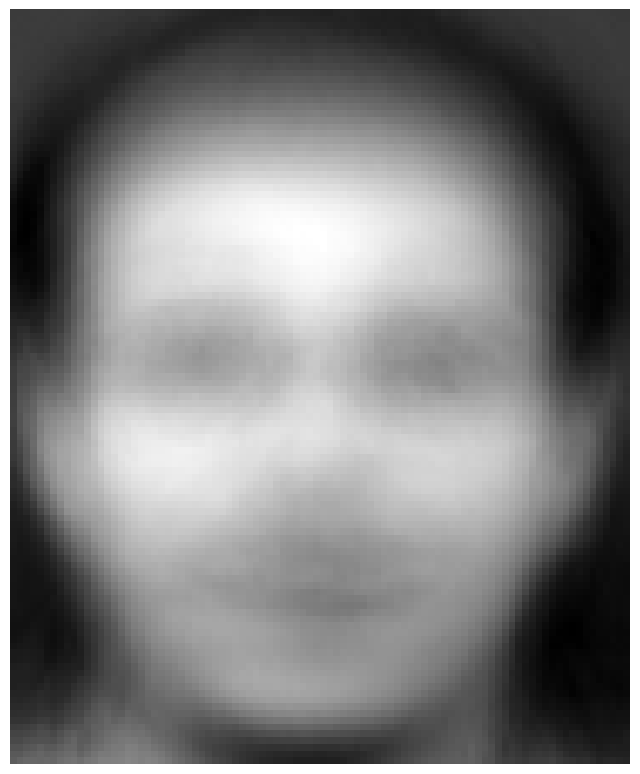

In [35]:
imagem_media = med.reshape(dimensao)
plt.figure(figsize=(8, 10))
plt.imshow(imagem_media, cmap='gray')
plt.axis('off') 
plt.show()

In [29]:
# PCA
n_componentes = 10
pca = PCA(n_componentes)
X_train_proj = pca.fit_transform(X_train)
X_test_proj = pca.transform(X_test) #Projetando as imagens de teste na base ortonormal dos componentes principais

In [30]:
#Classificando com PCA
y_pred, indices = knn(X_test_proj, X_train_proj)

acc = accuracy_score(y_test, y_pred)
print(f"\nAcurácia: {acc*100:.2f}%")

print("\nErros de Classificação:")
erros = 0
for verdadeiro, previsto in zip(y_test, y_pred):
    if verdadeiro != previsto:
        print(f"Era: {verdadeiro} → Classificado como: {previsto}")
        erros += 1

print(f"\nTotal de erros: {erros}")


Acurácia: 95.00%

Erros de Classificação:
Era: 10 → Classificado como: 38
Era: 35 → Classificado como: 40

Total de erros: 2


In [26]:
componentes_para_testar = list(range(1, 100, 1))
acuracias = []
variancias_explicadas = []

for n in componentes_para_testar:
    pca = PCA(n)
    X_train_proj = pca.fit_transform(X_train)
    X_test_proj = pca.transform(X_test)
    y_pred, _ = knn(X_test_proj, X_train_proj)
    acc = accuracy_score(y_test, y_pred)
    acuracias.append(acc)
    variancia = np.sum(pca.variancia_exp)
    variancias_explicadas.append(variancia)

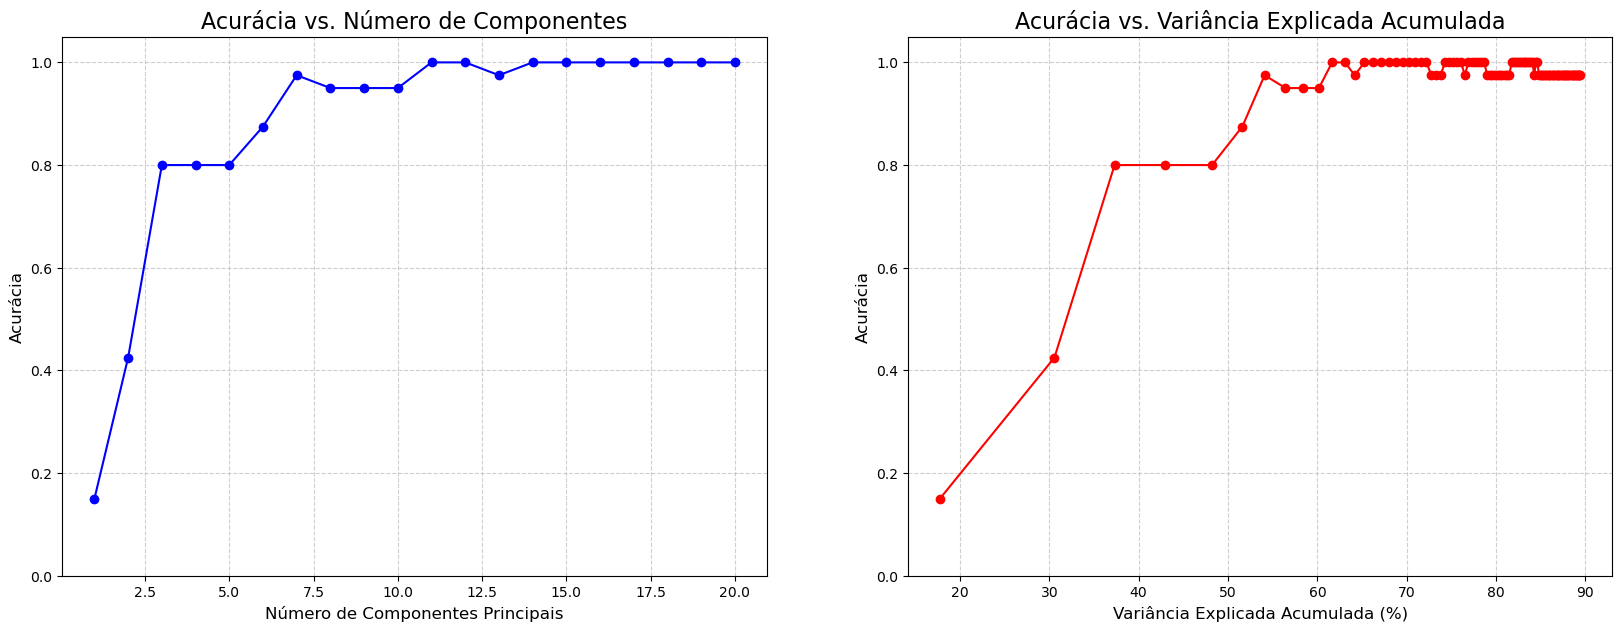

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
ax1.plot(componentes_para_testar[:20], acuracias[:20], marker='o', linestyle='-', color='b')
ax1.set_title('Acurácia vs. Número de Componentes', fontsize=16)
ax1.set_xlabel('Número de Componentes Principais', fontsize=12)
ax1.set_ylabel('Acurácia', fontsize=12)
ax1.set_ylim(0, 1.05)
ax1.grid(True, linestyle='--', alpha=0.6)
max_acc_idx = np.argmax(acuracias)
max_acc = acuracias[max_acc_idx]
best_n_components = componentes_para_testar[max_acc_idx]

variancias_percent = [v * 100 for v in variancias_explicadas]
ax2.plot(variancias_percent, acuracias, marker='o', linestyle='-', color='r')
ax2.set_title('Acurácia vs. Variância Explicada Acumulada', fontsize=16)
ax2.set_xlabel('Variância Explicada Acumulada (%)', fontsize=12)
ax2.set_ylabel('Acurácia', fontsize=12)
ax2.set_ylim(0, 1.05)
ax2.grid(True, linestyle='--', alpha=0.6)

plt.show()

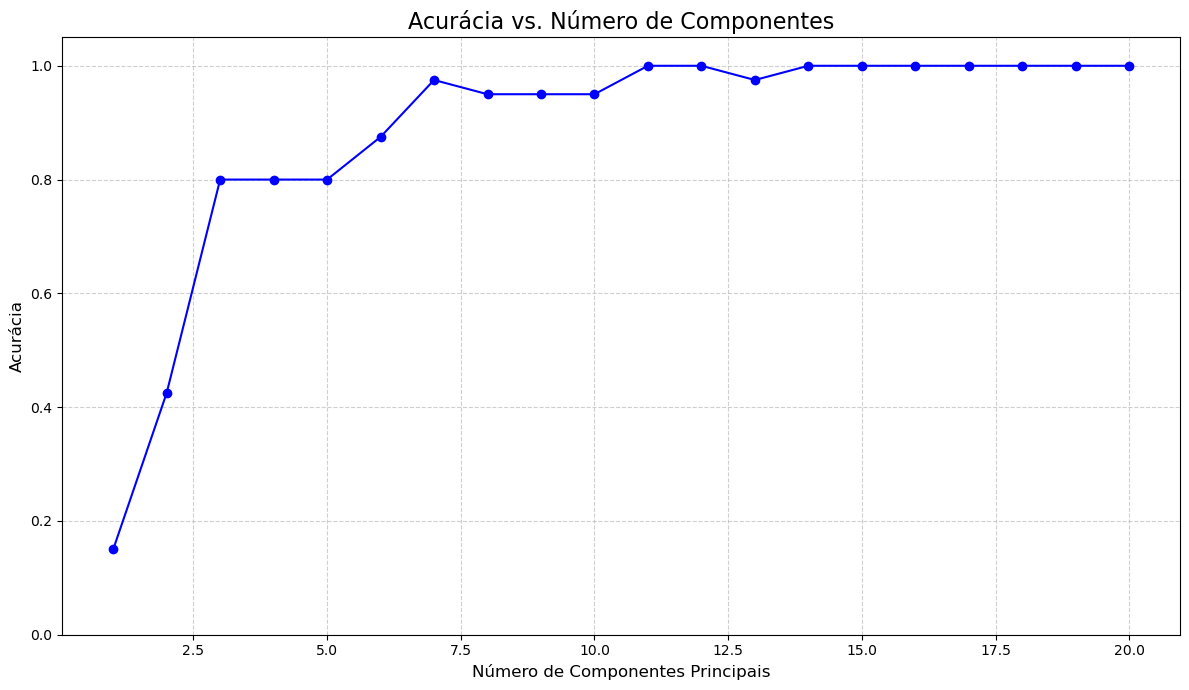

In [18]:
plt.figure(figsize=(12, 7))
plt.plot(componentes_para_testar[:20], acuracias[:20], marker='o', linestyle='-', color='b')
plt.title('Acurácia vs. Número de Componentes', fontsize=16)
plt.xlabel('Número de Componentes Principais', fontsize=12)
plt.ylabel('Acurácia', fontsize=12)
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

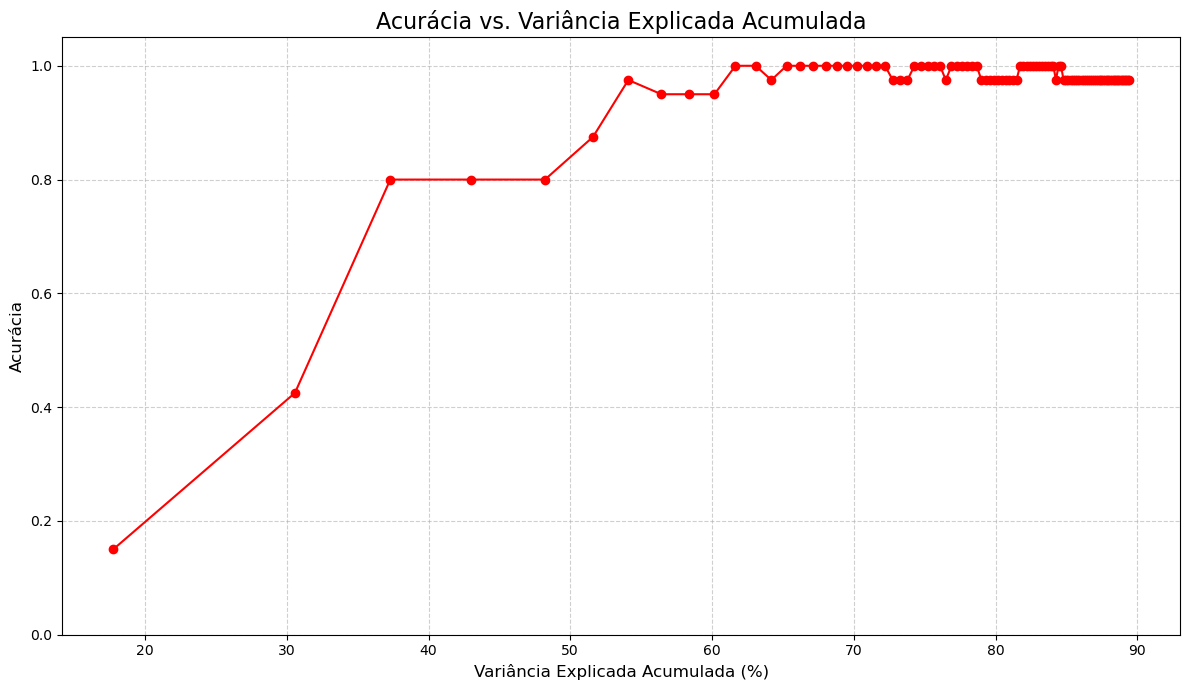

In [19]:
plt.figure(figsize=(12, 7))
plt.plot(variancias_percent, acuracias, marker='o', linestyle='-', color='r')
plt.title('Acurácia vs. Variância Explicada Acumulada', fontsize=16)
plt.xlabel('Variância Explicada Acumulada (%)', fontsize=12)
plt.ylabel('Acurácia', fontsize=12)
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

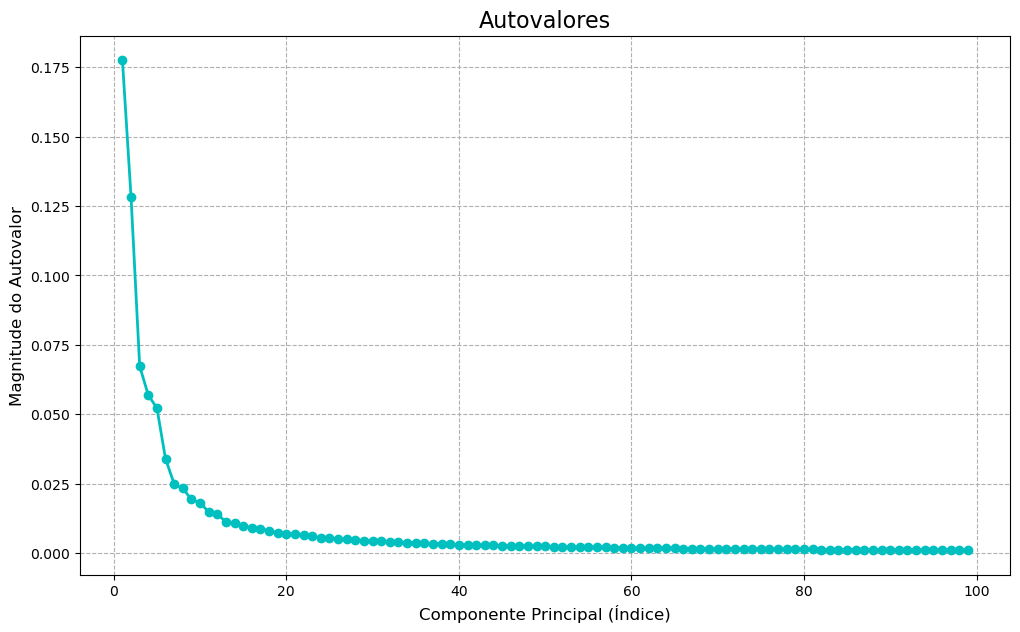

In [20]:
eigenvalues = pca.variancia_exp
plt.figure(figsize=(12, 7))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, 'o-', linewidth=2, color='c')
plt.title('Autovalores', fontsize=16)
plt.xlabel('Componente Principal (Índice)', fontsize=12)
plt.ylabel('Magnitude do Autovalor', fontsize=12)
plt.grid(True, linestyle='--')
plt.show()

In [21]:
print(X_train_proj.shape)
print(X_test_proj.shape)

(360, 99)
(40, 99)


In [22]:
print(pca.componentes().shape)
print(pca.VVT().shape)

(10304, 99)
(10304, 10304)


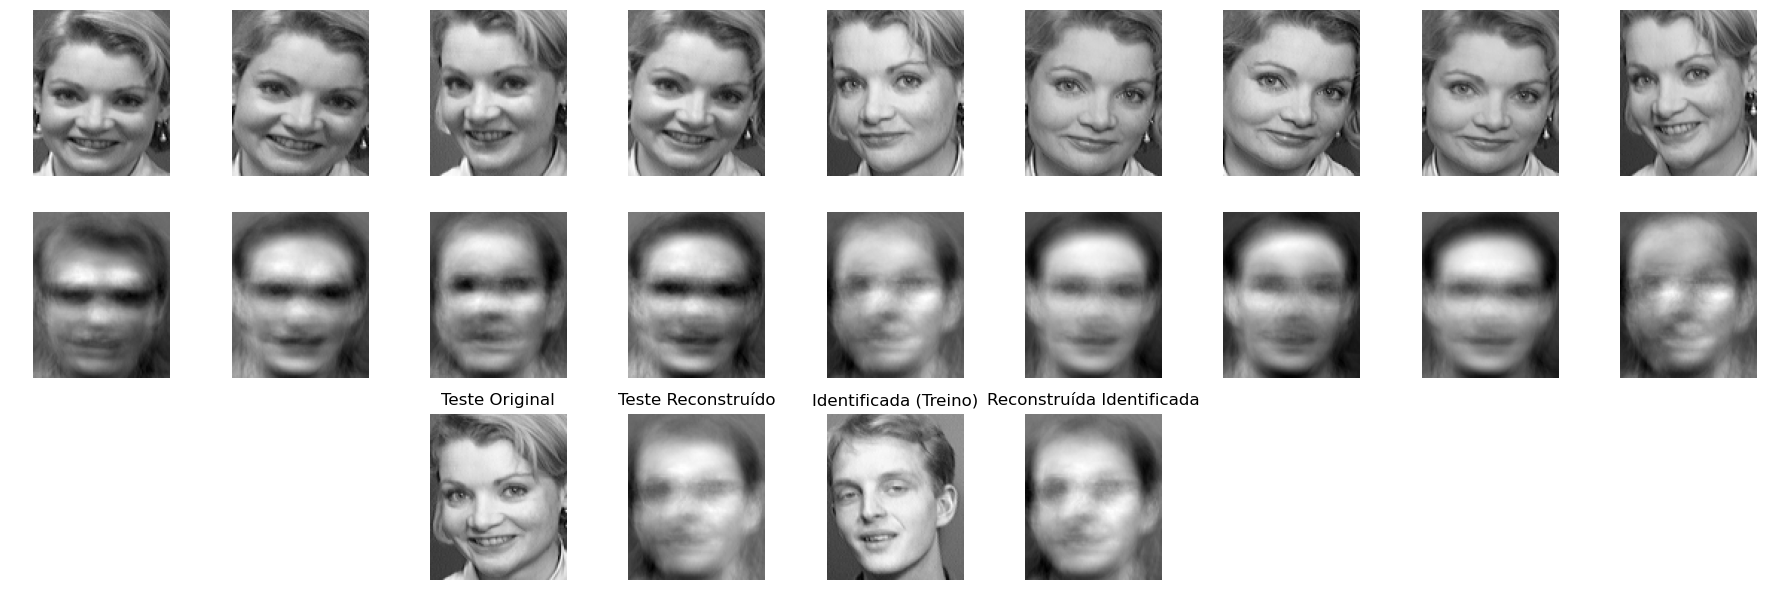

In [37]:
pessoa = '35'  # altere para quem quiser mostrar

indices_treino = [i for i, label in enumerate(y_train) if label == pessoa]
indices_teste = [i for i, label in enumerate(y_test) if label == pessoa]

imgs_treino_orig = X_train[indices_treino[:9]]

imgs_treino_proj = pca.transform(X_train[indices_treino[:9]])
imgs_treino_recon = pca.inverse_transform(imgs_treino_proj) 

img_teste_orig = X_test[indices_teste[0]]
img_teste_proj = pca.transform(X_test[indices_teste[0]].reshape(1, -1))
img_teste_recon = pca.inverse_transform(img_teste_proj)

X_test_proj = pca.transform(X_test)

y_pred, indices_nn = knn(X_test_proj, X_train_proj)

idx_teste = indices_teste[0]
idx_nn = indices_nn[idx_teste]

img_identificada_orig = X_train[idx_nn]
img_identificada_proj = pca.transform(X_train[idx_nn].reshape(1, -1))
img_identificada_recon = pca.inverse_transform(img_identificada_proj)

fig, axs = plt.subplots(3, 9, figsize=(18, 6))

# Linha 1: imagens originais de treino
for i in range(9):
    axs[0, i].imshow(imgs_treino_orig[i].reshape(dimensao), cmap='gray')
    axs[0, i].axis('off')
# Linha 2: imagens de treino reconstruídas
for i in range(9):
    axs[1, i].imshow(imgs_treino_recon[i].reshape(dimensao), cmap='gray')
    axs[1, i].axis('off')

# Linha 3: mostrar teste original, teste reconstruído, treino identificado e treino identificado reconstruído
for i in range(9):
    axs[2, i].axis('off')

axs[2, 2].imshow(img_teste_orig.reshape(dimensao), cmap='gray')
axs[2, 2].set_title("Teste Original")
axs[2, 3].imshow(np.clip(img_teste_recon.reshape(dimensao), 0, 255), cmap='gray')
axs[2, 3].set_title("Teste Reconstruído")
axs[2, 4].imshow(img_identificada_orig.reshape(dimensao), cmap='gray')
axs[2, 4].set_title("Identificada (Treino)")
axs[2, 5].imshow(np.clip(img_identificada_recon.reshape(dimensao), 0, 255), cmap='gray')
axs[2, 5].set_title("Reconstruída Identificada")

plt.tight_layout()
plt.show()


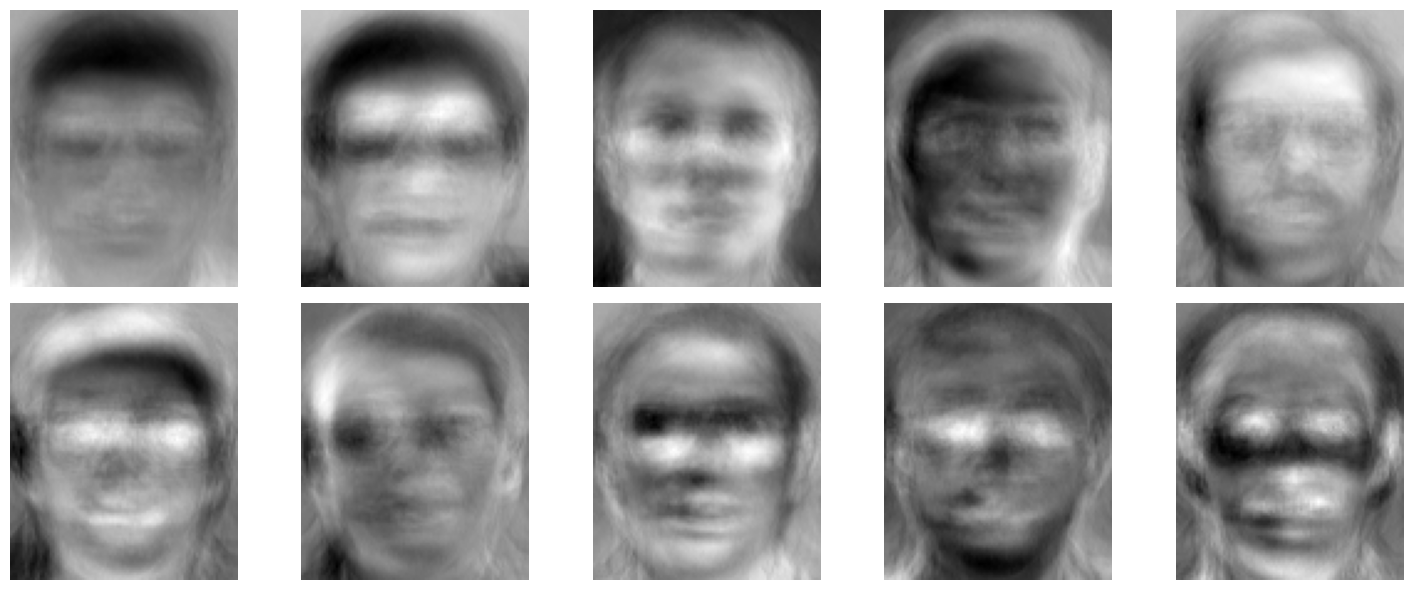

In [27]:
num_eigenfaces = 10

plt.figure(figsize=(15, 6))
for i in range(num_eigenfaces):
    eigenface = pca.componente(i).reshape(dimensao) 
    eigenface_img = 255 * (eigenface - eigenface.min()) / (eigenface.max() - eigenface.min())
    eigenface_img = eigenface_img.astype('uint8')

    plt.subplot(2, 5, i + 1)
    
    plt.imshow(eigenface_img, cmap='gray')
    #plt.title(f"Eigenface {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()